🎯 Objectif
 Construire, visualiser, évaluer et comparer un Arbre de Décision et une Random Forest à partir du dataset
 Titanic.

 🔹 Partie 1 – Chargement & Exploration

In [108]:
import pandas as pd

df = pd.read_csv('Titanic-Dataset.csv')
print(df.head(5))

print("\nTypes données:")
print(df.dtypes)
#df.info()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

T

In [109]:
total_passagers = len(df)
nb_survivants = df['Survived'].sum()
proportion_survivants = nb_survivants/total_passagers *100
print(f"nb survivants : {nb_survivants} \nnb total passagers : {total_passagers} \nProportion de survivants : {proportion_survivants:.2f}%")

nb survivants : 342 
nb total passagers : 891 
Proportion de survivants : 38.38%


In [110]:
nb_val_manquante = df.isnull().sum()
pourcentages = (nb_val_manquante / total_passagers) * 100
manquantes = pd.DataFrame({
    'nb_val_manquante': nb_val_manquante,
    '%': pourcentages
})
manquantes = manquantes[manquantes['nb_val_manquante']>0]
print(manquantes)

          nb_val_manquante          %
Age                    177  19.865320
Cabin                  687  77.104377
Embarked                 2   0.224467


� Partie 2 – Nettoyage & Préparation

In [111]:
age_median = df['Age'].median()

most_frequent_embarked = df['Embarked'].mode()[0]

df.fillna({'Age': age_median, 'Embarked': most_frequent_embarked}, inplace=True)


print(df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [112]:
df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)

PassengerId :
→ C’est juste un identifiant unique. Il n’a aucun lien avec la survie ou d’autres caractéristiques utiles pour l’analyse ou la prédiction.
Name :
→ Trop spécifique. Chaque nom est unique ou presque, donc il n’apporte pas directement de valeur en l'état.
Ticket :
→ Numéro très hétérogène, souvent non structuré. Pas vraiment utile sans traitement spécifique.
Cabin :
→ Contient trop de valeurs manquantes (beaucoup de NaN), donc difficile à exploiter efficacement.


In [113]:
df_original = pd.read_csv('Titanic-Dataset.csv')
df['Title'] = df_original['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
print(df['Title'].unique())


['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


🎯 Est-ce que Title est informatif ?
Oui ✅ ! Parce qu’il résume le statut social, l’âge ou le genre :

Master → jeune garçon

Miss, Mrs → femme (célibataire/mariée)

Dr, Rev, Col, etc. → statuts sociaux plus rares

Il peut aussi refléter des inégalités face à la survie

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


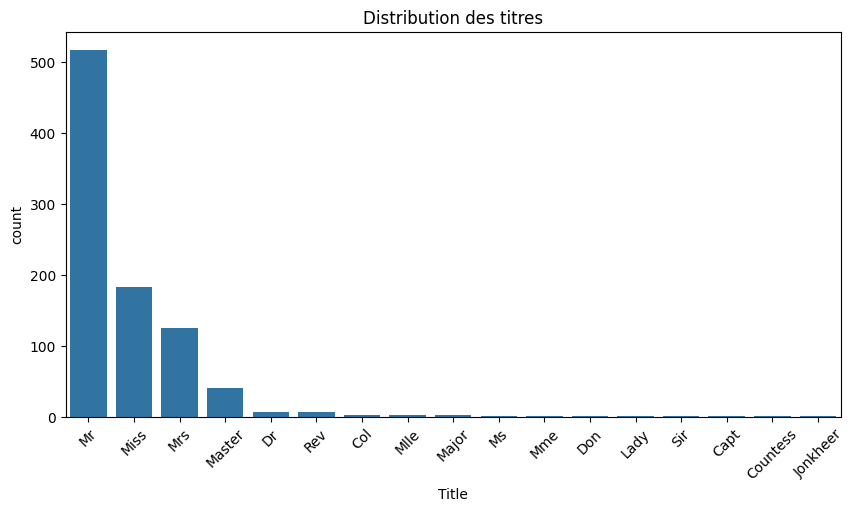

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df['Title'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Title', order=df['Title'].value_counts().index)
plt.title("Distribution des titres")
plt.xticks(rotation=45)
plt.show()


🎯 Pourquoi regrouper/fusionner certains titres ?
Certains titres sont très rares : ex. 'Countess', 'Jonkheer', 'Don', etc. → leur fréquence est trop faible pour apprendre quelque chose de fiable.

Certains titres veulent dire la même chose :

'Mme' est équivalent à 'Mrs'

'Mlle' et 'Ms' sont proches de 'Miss'

'Dr', 'Rev', 'Major', 'Col', 'Capt', 'Sir', 'Lady' peuvent être regroupés comme "Rare"

In [115]:
df['Title'] = df['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Major': 'Rare',
    'Col': 'Rare',
    'Capt': 'Rare',
    'Sir': 'Rare',
    'Lady': 'Rare',
    'Don': 'Rare',
    'Countess': 'Rare',
    'Jonkheer': 'Rare'
})

print(df['Title'].value_counts())


Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


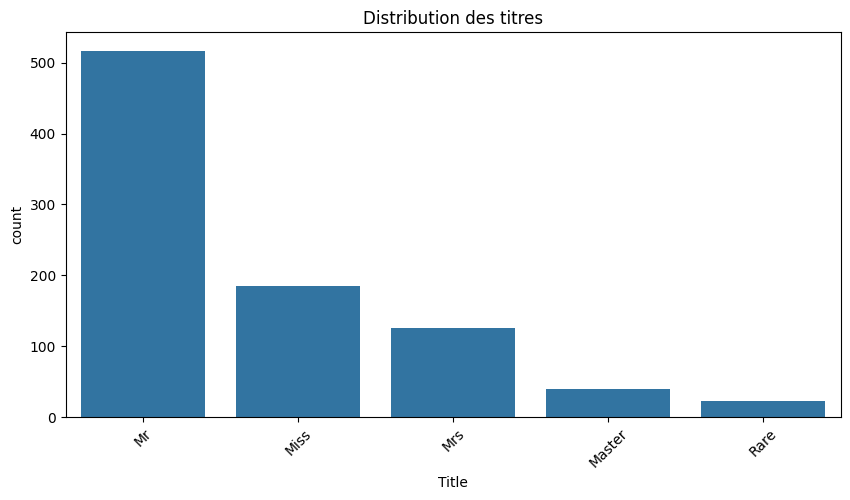

In [116]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Title', order=df['Title'].value_counts().index)
plt.title("Distribution des titres")
plt.xticks(rotation=45)
plt.show()

 🔹 Partie 3 – Encodage & Prétraitement

In [117]:
df['Sex'].unique()
df['Embarked'].unique()
#df['Title'].unique()



array(['S', 'C', 'Q'], dtype=object)

In [118]:
# Label Encoding pour Sex
from sklearn.preprocessing import LabelEncoder

le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])

# OneHot Encoding pour Embarked et Title
df = pd.get_dummies(df, columns=['Embarked', 'Title'])

# Convertir les colonnes booléennes en int
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

df.head()
#df.dtypes



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,1,22.0,1,0,7.2500,0,0,1,0,0,1,0,0
1,1,1,0,38.0,1,0,71.2833,1,0,0,0,0,0,1,0
2,1,3,0,26.0,0,0,7.9250,0,0,1,0,1,0,0,0
3,1,1,0,35.0,1,0,53.1000,0,0,1,0,0,0,1,0
4,0,3,1,35.0,0,0,8.0500,0,0,1,0,0,1,0,0


STANDARDISATION:
Pourquoi faire ça ?
Même si les arbres de décision et Random Forests ne sont pas sensibles à l’échelle des variables (car ils ne font pas de calculs de distance), il peut être utile de standardiser dans certains cas :

✅ Raisons de standardiser :
Comparer les variables ou les visualiser sur la même échelle.

Travailler avec d'autres modèles plus tard (comme KNN, SVM, Régression...), qui eux sont sensibles à l’échelle.

Optimiser l’apprentissage dans des pipelines contenant des étapes combinées (ex : PCA, clustering...).

Certaines implémentations (ex : avec sklearn) fonctionnent mieux ou plus vite si les données sont centrées.

In [119]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

age_original = df['Age'].copy()
fare_original = df['Fare'].copy()

scaler = StandardScaler()
df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.hist(age_original, bins=30, color='skyblue', edgecolor='black')
# plt.title('Âge - Avant Standardisation')
# plt.xlabel('Âge')
# plt.ylabel('Nombre de passagers')

# plt.subplot(1, 2, 2)
# plt.hist(df['Age'], bins=30, color='orange', edgecolor='black')
# plt.title('Âge - Après Standardisation')
# plt.xlabel('Âge standardisé')

# plt.tight_layout()
# plt.show()

# # pour Fare
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.hist(fare_original, bins=30, color='lightgreen', edgecolor='black')
# plt.title('Tarif (Fare) - Avant Standardisation')
# plt.xlabel('Tarif')
# plt.ylabel('Nombre de passagers')

# plt.subplot(1, 2, 2)
# plt.hist(df['Fare'], bins=30, color='salmon', edgecolor='black')
# plt.title('Tarif (Fare) - Après Standardisation')
# plt.xlabel('Tarif standardisé')

# plt.tight_layout()
# plt.show()

In [120]:
from sklearn.model_selection import train_test_split

#print(df.head())
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# trained_columns = X_train.columns.tolist()
# print(trained_columns)


🔹 Partie 4 – Visualisation & Analyse Exploratoire

<Axes: >

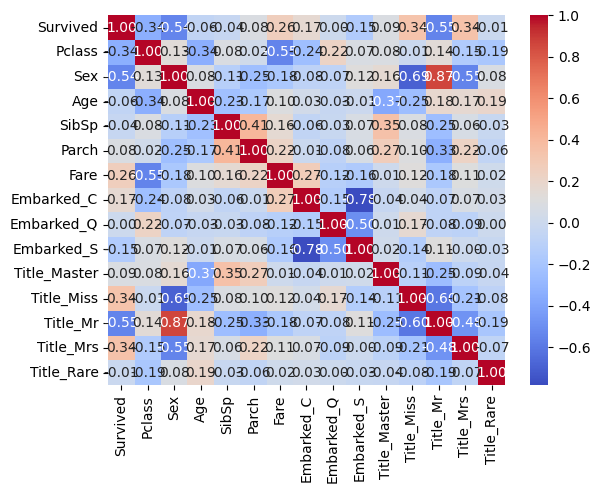

In [121]:
import seaborn as sns

correlations_matrix = df.corr()

sns.heatmap(correlations_matrix,  annot=True, fmt=".2f", cmap="coolwarm")

Les variables les plus corrélé avec survived :
Sex
title_Mr
title_Miss
title_Mrs
Pclass
Fare

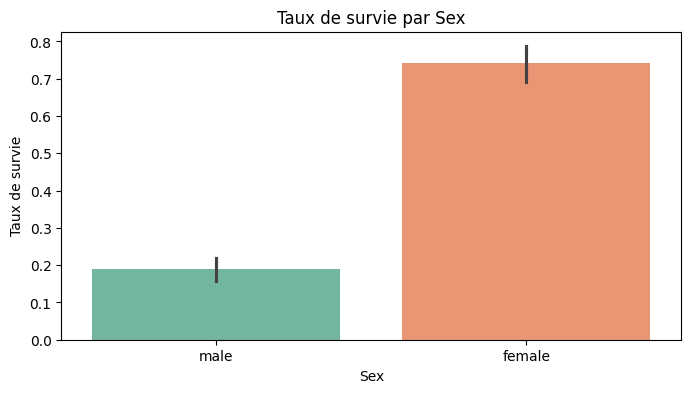

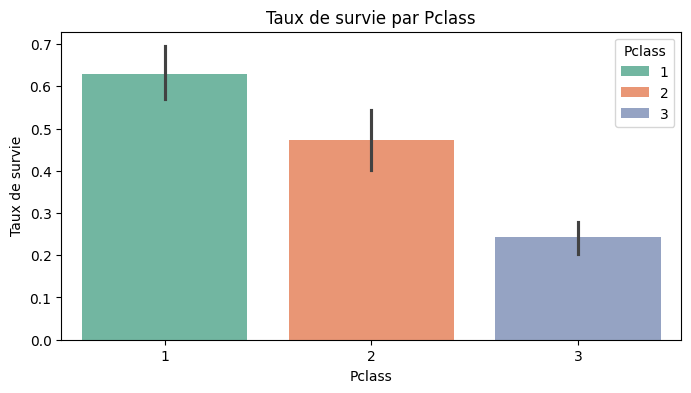

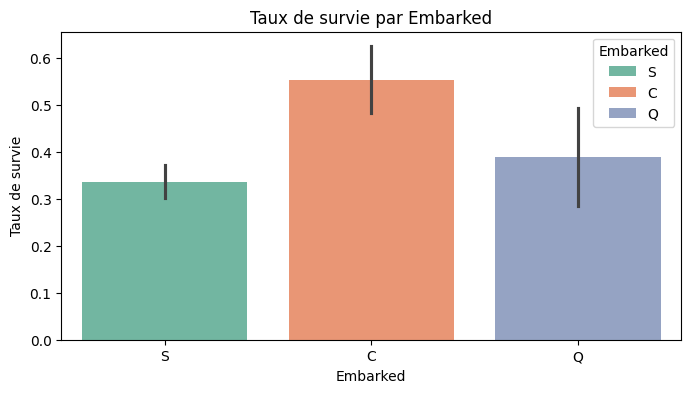

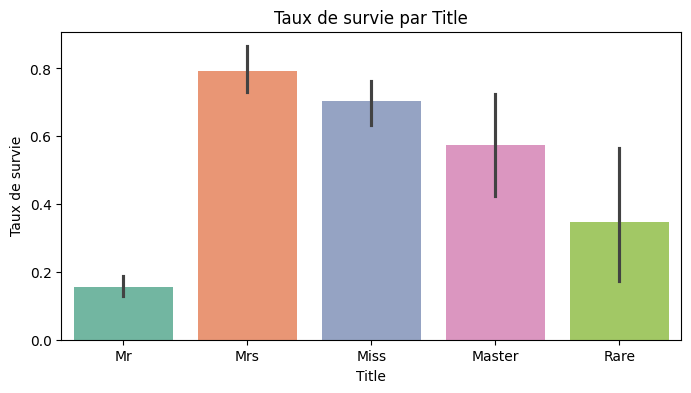

In [ ]:
#Pour le barplot, Utiliser les données avant encodage
df_orig = pd.read_csv('Titanic-Dataset.csv')
df_orig['Title'] = df_orig['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
df_orig['Title'] = df_orig['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Major': 'Rare',
    'Col': 'Rare',
    'Capt': 'Rare',
    'Sir': 'Rare',
    'Lady': 'Rare',
    'Don': 'Rare',
    'Countess': 'Rare',
    'Jonkheer': 'Rare'
})

# Fonction générale pour afficher un barplot
def plot_survival_rate_by(column):
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_orig, x=column,hue=column, y='Survived', estimator='mean', palette='Set2')
    plt.title(f'Taux de survie par {column}')
    plt.ylabel('Taux de survie')
    plt.xlabel(column)
    plt.show()

# Appliquer aux variables demandées
plot_survival_rate_by('Sex')
plot_survival_rate_by('Pclass')
plot_survival_rate_by('Embarked')
plot_survival_rate_by('Title')

� Partie 5 – Arbre de Décision

In [144]:
from sklearn.model_selection import train_test_split

#print(df.head())
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# trained_columns = X_train.columns.tolist()
# print(trained_columns)

In [145]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

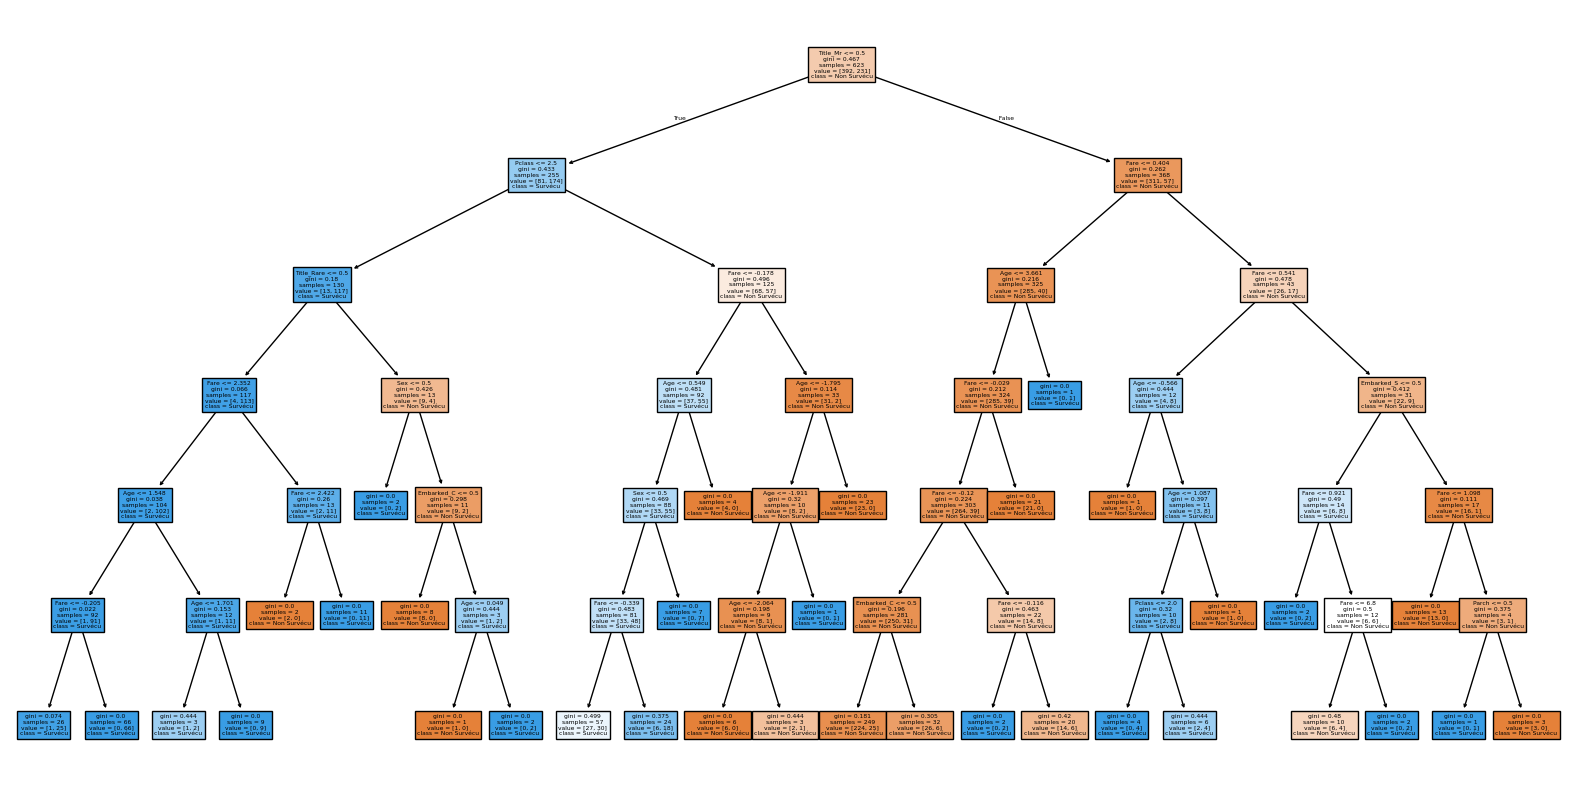

In [146]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=['Non Survécu', 'Survécu'], filled=True)
plt.show()

Accuracy: 0.8246268656716418
Précision: 0.8018867924528302
Rappel: 0.7657657657657657
F1 Score: 0.783410138248848


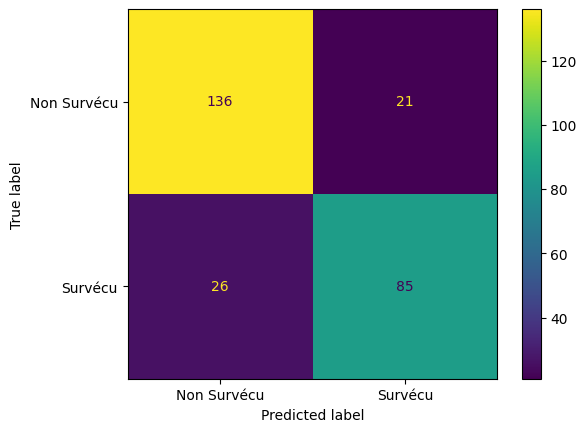

In [147]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Prédictions
y_pred = clf.predict(X_test)

# Accuracy (taux de bonnes prédictions)
print("Accuracy:", accuracy_score(y_test, y_pred))

#Précision (quand il dit 'survécu', a-t-il raison ?)
print("Précision:", precision_score(y_test, y_pred))

# Rappel (combien de vrais survivants retrouvés ?)
print("Rappel:", recall_score(y_test, y_pred))

#F1-score (moyenne entre précision et rappel)
print("F1 Score:", f1_score(y_test, y_pred))

# ✅ Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Survécu', 'Survécu'])
disp.plot()
plt.show()


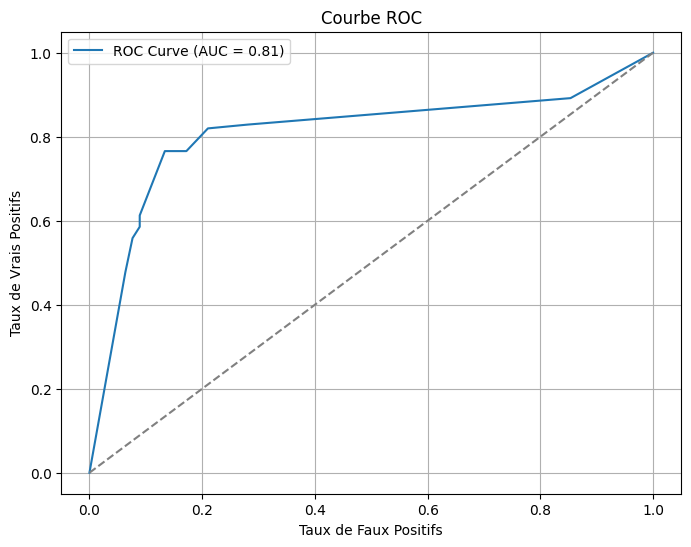

In [148]:
from sklearn.metrics import roc_curve, roc_auc_score

# Prédire les probabilités
y_proba = clf.predict_proba(X_test)[:, 1]

# Calculer la courbe
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Afficher
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.grid()
plt.show()


🔹 Partie 6 – Random Forest

In [171]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=4)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [172]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Précision:", precision_score(y_test, y_pred_rf))
print("Rappel:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

Accuracy: 0.8283582089552238
Précision: 0.8571428571428571
Rappel: 0.7027027027027027
F1 Score: 0.7722772277227723


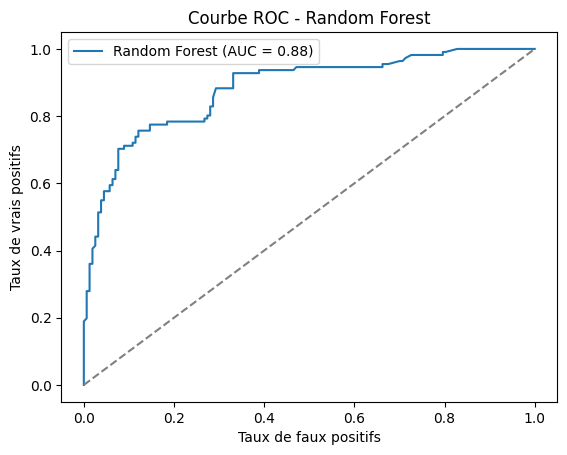

In [152]:
from sklearn.metrics import roc_curve, auc

y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC - Random Forest")
plt.legend()
plt.show()


In [153]:
import pandas as pd

# Créer un DataFrame pour mieux visualiser
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Afficher les 3 plus importantes
print(importances.head(3))


     Feature  Importance
11  Title_Mr    0.252411
1        Sex    0.223400
0     Pclass    0.121429


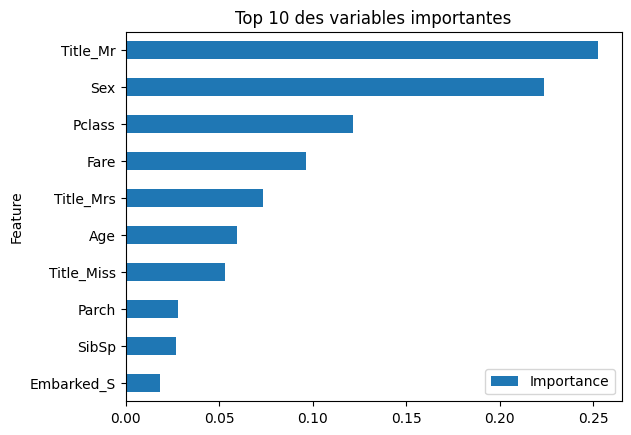

In [160]:
importances.head(10).plot(kind='barh', x='Feature', y='Importance', title='Top 10 des variables importantes')
plt.gca().invert_yaxis()
plt.show()


� Partie 7 – Analyse & Optimisation

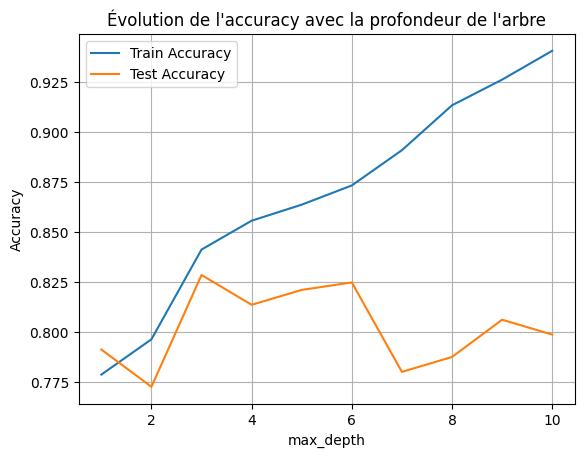

In [173]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_accuracies = []
test_accuracies = []

for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'accuracy avec la profondeur de l\'arbre')
plt.legend()
plt.grid()
plt.show()


In [174]:
from sklearn.model_selection import cross_val_score

# Arbre
tree = DecisionTreeClassifier(max_depth=6, random_state=0)
scores_tree = cross_val_score(tree, X, y, cv=5)

# Random Forest
rf = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=0)
scores_rf = cross_val_score(rf, X, y, cv=5)

print("Decision Tree CV mean accuracy:", scores_tree.mean())
print("Random Forest CV mean accuracy:", scores_rf.mean())


Decision Tree CV mean accuracy: 0.8147887765990836
Random Forest CV mean accuracy: 0.8226727763480008


In [175]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 150]
}

rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy (cv) :", grid_search.best_score_)

# Évaluer sur test
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Accuracy sur les données de test :", test_accuracy)


Meilleurs paramètres : {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 50}
Meilleure accuracy (cv) : 0.8410967741935484
Accuracy sur les données de test : 0.8283582089552238


💡 Bilan final
Modèle	Accuracy Test	Précision	Rappel	F1 Score	Cross-Val
Decision Tree (d=6)	0.824	0.801	0.765	0.783	0.814
Random Forest (d=6)	0.817	0.837	0.693	0.758	0.822
Random Forest optimisé	0.828	0.857	0.702	0.772	0.841

➡️ Conclusion :
🔹 La Random Forest optimisée avec GridSearchCV est la meilleure en termes de performance et robustesse.

🔹 Partie 8 – Conclusion

✅ Quel modèle est le plus performant ?
D’après les résultats :

Random Forest (avec GridSearchCV) donne la meilleure performance :

Accuracy CV : 0.841

Accuracy Test : 0.828

Il est plus stable (meilleur score moyen en cross-validation) que l’arbre de décision.

Ses scores en précision sont plus élevés, même si le rappel est parfois un peu plus bas que l’arbre simple.

➡️ Conclusion : Random Forest est globalement plus performant.

🎯 Quelle variable est la plus discriminante ?
Selon les importances de variables du modèle Random Forest :

Variable	Importance
Title_Mr	0.252
Sex	0.223
Pclass	0.121

🔍 Analyse :
Title_Mr est la variable la plus discriminante. Cela montre que le titre social d’un passager (Monsieur, Madame, etc.) est fortement corrélé à sa probabilité de survie.

Par exemple, les femmes (Title_Mrs, Title_Miss) ont eu plus de chances d’être secourues que les hommes (Title_Mr).

Le sexe arrive en deuxième, ce qui confirme cette tendance.

La classe (Pclass) a également un impact : les passagers de 1ère classe ont eu un meilleur taux de survie.

➡️ En résumé : le statut social et le genre jouent un rôle central dans la prédiction de la survie.

⚖️ Avantages / Inconvénients des modèles
		
| Modèle | Avantages | Inconvénients |

| Arbre de Décision | ✅ Simple à comprendre (arbre graphique clair)
✅ Rapide à entraîner | ❌ Moins stable (sensible aux petits changements)
❌ Moins précis |
| Random Forest | ✅ Meilleure performance
✅ Moins d’overfitting ✅ Plus stable | ❌ Plus lent à entraîner
❌ Plus complexe à interpréter|
	

🚀 Pistes d'amélioration possibles

1. Enrichissement des données (Feature Engineering)
Créer de nouvelles variables à partir des existantes :

Extraire la taille de la famille (SibSp + Parch) pour détecter l’effet de voyager seul ou en groupe.

Catégoriser l’âge (Age) en tranches (enfant, adulte, senior) pour mieux capter les différences de survie.